# 1. Import libraries

In [1]:
# data manipulation
import pandas as pd
from darts import TimeSeries

# models
from darts.models import NaiveSeasonal

# warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Load data

In [2]:
dataset = pd.read_csv('../results/prepared_data.csv')

# set the column type for column with date
dataset['Data'] = pd.to_datetime(dataset['Data'], format='%Y-%m-%d')

dataset

,Data,GŁOGÓW (151160060) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],BARDO ŚLĄSKIE (250160410) Suma opadów [mm],BIERUTÓW (251170270) Suma opadów [mm],BOLESŁAWÓW (250160610) Suma opadów [mm],BOLKÓW (250160030) Suma opadów [mm],BORÓW (250160070) Suma opadów [mm],BRZEG (250170050) Suma opadów [mm],BRZEG DOLNY (251160230) Suma opadów [mm],...,TARNÓW (250160360) Suma opadów [mm],TRZEBNICA (251170210) Suma opadów [mm],TWARDOCICE (251150280) Suma opadów [mm],WALIM (250160270) Suma opadów [mm],WROCŁAW-STRACHOWICE (351160424) Suma opadów [mm],ZIELENIEC (250160530) Suma opadów [mm],ZIELINA (250170280) Suma opadów [mm],ŹRÓDŁA (251160370) Suma opadów [mm],średnia Suma opadów [mm],mediana Suma opadów [mm]
0,2012-01-01,199.0,119.0,0.2,0.5,0.5,0.7,0.2,NaN,0.8,...,0.8,NaN,0.5,0.0,0.3,7.0,0.5,NaN,0.721875,0.5
1,2012-01-02,197.0,116.0,NaN,1.1,1.0,0.8,0.0,0.3,0.6,...,0.0,0.5,2.2,0.1,0.2,1.3,NaN,NaN,0.888889,0.6
2,2012-01-03,197.0,118.0,2.2,0.9,5.6,NaN,0.0,NaN,0.1,...,0.0,0.1,NaN,0.2,0.1,9.5,NaN,NaN,1.406667,0.2
3,2012-01-04,204.0,127.0,2.4,0.1,12.5,NaN,NaN,0.6,0.5,...,1.1,1.8,0.2,5.2,0.0,12.6,0.9,NaN,3.620270,1.5
4,2012-01-05,205.0,153.0,8.9,7.1,23.0,10.2,0.5,1.0,3.0,...,6.6,8.8,9.3,12.9,2.5,46.0,6.1,NaN,10.271795,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2021-12-27,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0
3649,2021-12-28,NaN,NaN,2.4,0.0,2.8,1.2,5.7,3.1,2.8,...,0.6,NaN,3.0,0.2,3.5,6.7,4.5,3.8,2.206579,2.1
3650,2021-12-29,NaN,NaN,0.2,2.3,0.0,0.5,0.7,1.0,0.5,...,0.1,NaN,0.8,0.0,1.3,3.2,1.1,0.9,0.562500,0.5
3651,2021-12-30,NaN,NaN,1.6,6.2,2.0,3.4,4.4,5.5,4.7,...,0.9,NaN,2.4,1.5,4.6,10.2,5.6,4.2,4.215789,4.2


In [3]:
hierarchy = pd.read_csv('../results/prepared_hierarchy.csv')

hierarchy

,id_meteo,name_meteo,id_hydro,name_hydro
0,251160080,GŁOGÓW,151160060,GŁOGÓW
1,350180540,RACIBÓRZ,150180060,RACIBÓRZ-MIEDONIA


In [4]:
hydro_cols = [f"{stations['name_hydro']} ({stations['id_hydro']}) Stan wody [cm]" for _, stations in hierarchy.loc[
                                            :, ['id_hydro', 'name_hydro']].drop_duplicates().iterrows()]
meteo_cols = [f"{stations['name_meteo']} ({stations['id_meteo']}) Suma opadów [mm]" for _, stations in hierarchy.loc[
                                            hierarchy['id_meteo']!=0, ['id_meteo', 'name_meteo']].drop_duplicates().iterrows()]

In [5]:
# Water level
dataset_grouped_water_level = dataset.loc[:, ['Data']+hydro_cols].copy()
dataset_grouped_water_level = dataset_grouped_water_level.melt(id_vars=['Data'])
dataset_grouped_water_level['id_hydro'] = dataset_grouped_water_level['variable'].str.split('(', 1).str[1].str.split(')',
                                                                                                       1).str[0].astype(int)
dataset_grouped_water_level.rename({'value': 'Stan wody [cm]'}, axis=1, inplace=True)
dataset_grouped_water_level = dataset_grouped_water_level[['Data', 'id_hydro', 'Stan wody [cm]']]
dataset_grouped_water_level

,Data,id_hydro,Stan wody [cm]
0,2012-01-01,151160060,199.0
1,2012-01-02,151160060,197.0
2,2012-01-03,151160060,197.0
3,2012-01-04,151160060,204.0
4,2012-01-05,151160060,205.0
...,...,...,...
7301,2021-12-27,150180060,NaN
7302,2021-12-28,150180060,NaN
7303,2021-12-29,150180060,NaN
7304,2021-12-30,150180060,NaN


In [6]:
# Rain
dataset_grouped_rain = dataset.loc[:, ['Data']+meteo_cols].copy()
dataset_grouped_rain = dataset_grouped_rain.melt(id_vars=['Data'])
dataset_grouped_rain['id_meteo'] = dataset_grouped_rain['variable'].str.split('(', 1).str[1].str.split(')',
                                                                                                       1).str[0].astype(int)
dataset_grouped_rain.rename({'value': 'Suma opadów [mm]'}, axis=1, inplace=True)
dataset_grouped_rain = dataset_grouped_rain[['Data', 'id_meteo', 'Suma opadów [mm]']]
dataset_grouped_rain

,Data,id_meteo,Suma opadów [mm]
0,2012-01-01,251160080,0.1
1,2012-01-02,251160080,1.0
2,2012-01-03,251160080,NaN
3,2012-01-04,251160080,0.9
4,2012-01-05,251160080,6.4
...,...,...,...
7301,2021-12-27,350180540,0.0
7302,2021-12-28,350180540,1.8
7303,2021-12-29,350180540,0.1
7304,2021-12-30,350180540,2.1


In [7]:
dataset_grouped = hierarchy.copy()
dataset_grouped = pd.merge(dataset_grouped, dataset_grouped_water_level, how='inner', on=['id_hydro'])
dataset_grouped = pd.merge(dataset_grouped, dataset_grouped_rain, how='left', on=['Data', 'id_meteo'])

dataset_grouped

,id_meteo,name_meteo,id_hydro,name_hydro,Data,Stan wody [cm],Suma opadów [mm]
0,251160080,GŁOGÓW,151160060,GŁOGÓW,2012-01-01,199.0,0.1
1,251160080,GŁOGÓW,151160060,GŁOGÓW,2012-01-02,197.0,1.0
2,251160080,GŁOGÓW,151160060,GŁOGÓW,2012-01-03,197.0,NaN
3,251160080,GŁOGÓW,151160060,GŁOGÓW,2012-01-04,204.0,0.9
4,251160080,GŁOGÓW,151160060,GŁOGÓW,2012-01-05,205.0,6.4
...,...,...,...,...,...,...,...
7301,350180540,RACIBÓRZ,150180060,RACIBÓRZ-MIEDONIA,2021-12-27,NaN,0.0
7302,350180540,RACIBÓRZ,150180060,RACIBÓRZ-MIEDONIA,2021-12-28,NaN,1.8
7303,350180540,RACIBÓRZ,150180060,RACIBÓRZ-MIEDONIA,2021-12-29,NaN,0.1
7304,350180540,RACIBÓRZ,150180060,RACIBÓRZ-MIEDONIA,2021-12-30,NaN,2.1


In [8]:
pd.date_range(start=dataset_grouped['Data'].min(),
              end=dataset_grouped['Data'].max()).difference(dataset_grouped['Data'].unique())

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

# 3. Save as TimeSeries Object

In [9]:
dataset.loc[:, ['Data']+hydro_cols]

,Data,GŁOGÓW (151160060) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm]
0,2012-01-01,199.0,119.0
1,2012-01-02,197.0,116.0
2,2012-01-03,197.0,118.0
3,2012-01-04,204.0,127.0
4,2012-01-05,205.0,153.0
...,...,...,...
3648,2021-12-27,NaN,NaN
3649,2021-12-28,NaN,NaN
3650,2021-12-29,NaN,NaN
3651,2021-12-30,NaN,NaN


In [25]:
dataset_ts = TimeSeries.from_dataframe(df=dataset.loc[:, ['Data']+hydro_cols].dropna(),
                                       time_col='Data', value_cols=hydro_cols)

dataset_ts

<TimeSeries (DataArray) (Data: 3592, component: 2, sample: 1)>
array([[[199.],
        [119.]],

       [[197.],
        [116.]],

       [[197.],
        [118.]],

       ...,

       [[214.],
        [124.]],

       [[208.],
        [122.]],

       [[209.],
        [121.]]])
Coordinates:
  * Data       (Data) datetime64[ns] 2012-01-01 2012-01-02 ... 2021-10-31
  * component  (component) object 'GŁOGÓW (151160060) Stan wody [cm]' 'RACIBÓ...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

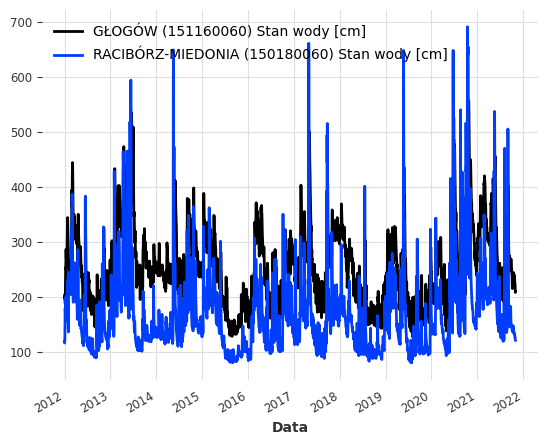

In [22]:
dataset_ts.plot()

# 3. Train Test Split

In [30]:
first_test_date = dataset.loc[:, ['Data']+hydro_cols].dropna()['Data'].values[-52]
first_test_date = pd.Timestamp(first_test_date)
first_test_date

Timestamp('2021-09-10 00:00:00')

In [31]:
train_dataset, test_dataset = dataset_ts.split_after(first_test_date)

# 4. Modelling & Backtests

In [32]:
# Założenie, że max horyzont to t0+30 days
horizons = 30

## 4.1 Baseline

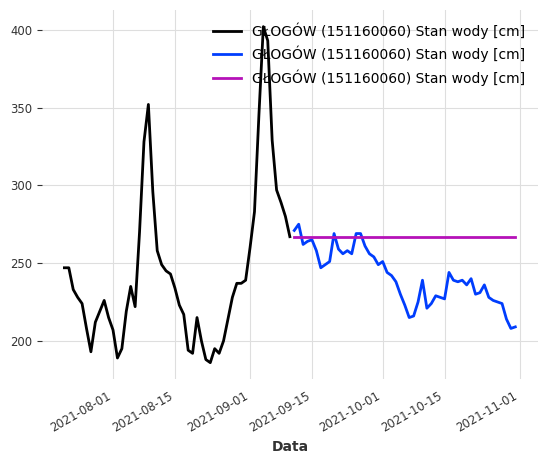

In [34]:
baseline_model = NaiveSeasonal(1)

baseline_model.fit(train_dataset)
train_dataset['GŁOGÓW (151160060) Stan wody [cm]'][-52:].plot()
test_dataset['GŁOGÓW (151160060) Stan wody [cm]'][-52:].plot()
baseline_model.predict(len(test_dataset))['GŁOGÓW (151160060) Stan wody [cm]'].plot()

## 4.2 BayesianRidge

### 4.2.1 Past-observed covariates

### 4.2.2 Past-observed covariates + Future-known covariates

## 4.3 Temporal Fusion Transformer

### 4.3.1 Past-observed covariates

### 4.3.2 Past-observed covariates + Future-known covariates

## 4.4 Linear mixed effects 

### 4.4.1 Past-observed covariates

### 4.4.2 Past-observed covariates + Future-known covariates

# 5. Save Model